# Relevant equations 

Equations follow *Geyer and Ralston 2011, Chapter 2: Dynamics of Strongly Stratified Estuaries*.

**Froude numbers for the top and bottom layers**:
$$
Fr_1^2 = \frac{Q_1^2}{g'\,W^2\,h_1^3}
$$

$$
Fr_2^2 = \frac{Q_2^2}{g'\,W^2\,h_2^3}
$$

 $Q_1$ and $Q_2$ are the volume fluxes in the top and bottom layers. $W$ is the channel width, and $h_1$ and $h_2$ are the layer heights. For a stationary salt wedge, $Q_2 = F_2 = 0$.


**The critical flow height for a given discharge (i.e. the height where Fr_1=1)**:

$$
h_{1C}=\left(\frac{Q_1^2}{W^2\,g'} \right)^{1/3}
$$

# Scalings for lab experiment with 1-inch rectangular tube

In [1]:
%matplotlib inline 
#to make plots show up in document

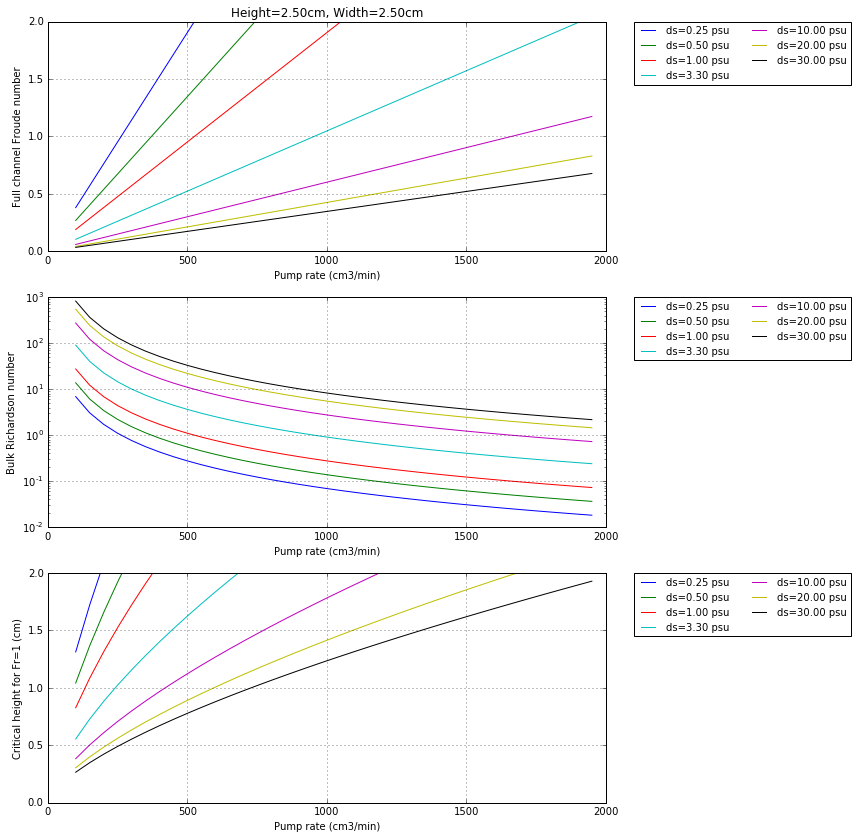

In [2]:
import numpy as np
import matplotlib.pylab as plt


#define some constants
beta = 0.8e-3 #haline contraction co-eff (1/psu)
g = 9.81 #m/s2

#Define flow parameters (for )
H = 0.025 #channel height (m)
W = 0.025 #channel width (m)

Q1_cc_min = np.arange(100, 2000, 50) #array of pump rates in cm3/min
Q1_m3_sec = Q1_cc_min*(1e-6/60) #pump rates in m3/sec
u1_m3_sec = Q1_m3_sec/(W*H)
dS_arr = np.array([0.25, 0.5, 1, 3.3, 10, 20, 30]) #array of some salinity values (psu)
g_p_arr = dS_arr*beta*g

fig, axes = plt.subplots(3,1, figsize=(10,14))
axes = axes.flatten()
#loop over each g' value 
for i,g_p in enumerate(g_p_arr):
    
    #compute full-channel froude number as function of flow rate
    Ff_i = Q1_m3_sec/(g_p*H**2*W**3)**(0.5)
    #compute bulk richardson number as function of flow rate
    Ri_i = g_p*H/(Q1_m3_sec/(H*W))**2
    #compute critical height as function of flow rate
    h_1c = ((Q1_m3_sec)**2/(W**2*g_p))**(1./3)
    
    #plot values 
    axes[0].plot(Q1_cc_min, Ff_i, label='ds=%.2f psu' %dS_arr[i])
    axes[1].semilogy(Q1_cc_min, Ri_i, label='ds=%.2f psu' %dS_arr[i])
    axes[2].plot(Q1_cc_min, h_1c*100, label='ds=%.2f psu' %dS_arr[i])

plt.sca(axes[0])
plt.title("Height=%.2fcm, Width=%.2fcm" %(H*100, W*100))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10, ncol=2)
plt.ylabel("Full channel Froude number")
plt.xlabel("Pump rate (cm3/min)")
plt.ylim(0, 2)
plt.grid(True)

plt.sca(axes[1])
plt.legend(loc=0, ncol=2, fontsize=10)
plt.ylabel("Bulk Richardson number")
plt.xlabel("Pump rate (cm3/min)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10, ncol=2)
plt.grid(True)

plt.sca(axes[2])
plt.legend(loc=0, ncol=2, fontsize=10)
plt.ylabel("Critical height for Fr=1 (cm)")
plt.xlabel("Pump rate (cm3/min)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10, ncol=2)
plt.grid(True)
plt.ylim(0, 2)

plt.savefig("flow_properties_1inch_tube.pdf", bbox_inches='tight')

# Salt wedge shape for 1-inch rectangular tube


**Steady state horizontal momentum balance across the wedge**:

From equation 18 in Geyer and Ralston 2011:

$$
\frac{\partial h_i}{\partial x} = \pm\,C_i\,\frac{F_1^2}{1-F_1^2}\,\frac{H}{h_2}
$$

where $H = h_1 + h_2$ is the height of the channel. The above represents a balance between the pressure gradient associated with the slope of the interface and the acceleration (or drag) by the fast flowing top layer. Here, the channel is assumed to have a flat bottom channel and constant width. The slope gradient become infinite where $h_2=0$ and $F_1=1$. $h_2=0$ occurs where the interface intersects the bed.

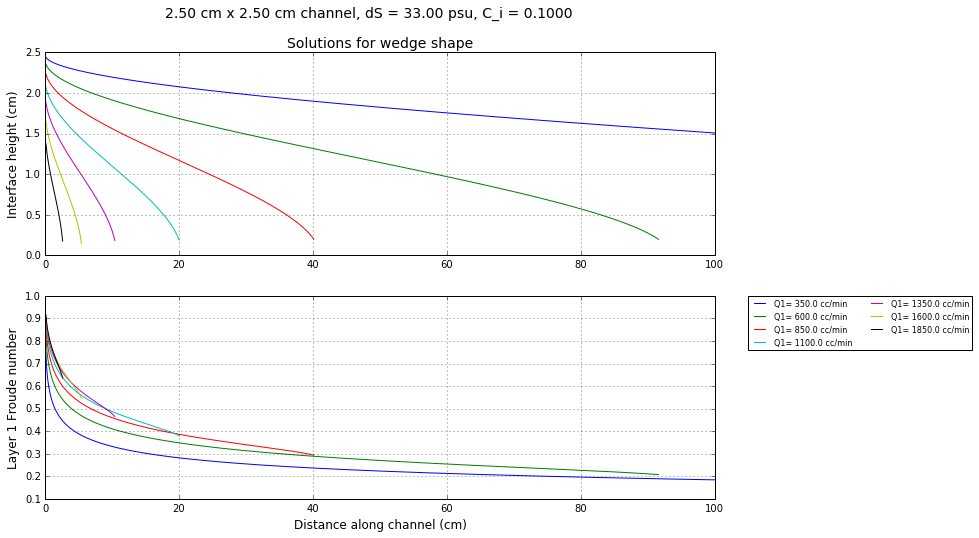

In [8]:
from scipy.integrate import odeint
import scipy.integrate as spi

dS = 33 #assume sea water salinity
C_i = 1e-1 #interfacial drag coefficient

#Define flow parameters
H = 0.025 #channel height (m)
W = 0.025 #channel width (m)

Q1_cc_min = np.arange(350, 2000, 250) #array of pump rates in cm3/min
Q1_m3_sec = Q1_cc_min*(1e-6/60) #pump rates in m3/sec
u1_m3_sec = Q1_m3_sec/(W*H)

#Define function to compute froude number for convenience
def Froude(u, g_p, h):
    
    return u/np.sqrt(g_p*h)


#Define function for ode-solver to get interface height:
def interface_shape(t, y, u1, g_p, C_i, H):
    #t=x, y=hi=h2, assuming flat bottom
    h1 = H-y[0]
    F1 = Froude(u1, g_p, h1) 
    dh = -C_i*(F1**2/(1-F1**2))*(H/y[0])
    
    return [dh]



#get interface for different outflow speeds
hi_ls = []
F1_ls = []
x_ls = []
for q1 in Q1_m3_sec:
    
    u1 = q1/(H*W)
    g_p1 = beta*dS*g
    
    #define initial h1 so that Froude number = 0.9999 - just below critical
    F1_0 = 0.9999
    h1_0 = u1**2/(F1_0**2*dS*beta*g) 
    h2_0 = H-h1_0
    
    
    #define initial conditions
    h2_0_arr = np.array([h2_0]) 
    x_end = 1 #meters
    
    #load and intialize interface model
    dx = 0.001 #meter
    ode =  spi.ode(interface_shape) #
    ode.set_f_params(u1, g_p1, C_i, H)

    ode.set_integrator('lsoda')
    ode.set_initial_value(h2_0_arr,t=0)

    ts = []
    ys = []
    #intergrate interface equation
    while ode.successful() and ode.t < x_end and ode.y[0]>0.002:
        #ode.t is the independent variable (x)
        #ode.y is the solution at x (h_i)
        ode.integrate(ode.t + dx) 
        ts.append(ode.t)
        ys.append(ode.y[0])
        
        
    x = np.array(ts)
    hi = np.array(ys)
    F1 = Froude(u1, g_p1, (H-hi)) 
    
    x_ls.append(x)
    hi_ls.append(hi)
    F1_ls.append(F1)
    
    
plt.figure(figsize=(12,8))

for i in range(len(F1_ls)):
    
    plt.subplot(211)
    plt.plot(x_ls[i]*100, np.array(hi_ls[i]*100), label='Q1= %.1f cc/min'%Q1_cc_min[i])
    #plt.xlabel("Distance along channel (cm)", fontsize=12)
    plt.ylabel("Interface height (cm)", fontsize=12)
    plt.title ("Solutions for wedge shape", fontsize=14)
    plt.xlim(0, 100)
    plt.grid(True)
    

    plt.subplot(212)
    plt.plot(x_ls[i]*100, np.array(F1_ls[i]), label='Q1= %.1f cc/min'%Q1_cc_min[i])
    plt.xlabel("Distance along channel (cm)", fontsize=12)
    plt.ylabel("Layer 1 Froude number", fontsize=12)
    #plt.legend(loc=0, fontsize=8, ncol=2)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8, ncol=2)
    plt.xlim(0, 100)
    plt.grid(True)

plt.suptitle("%.2f cm x %.2f cm channel, dS = %.2f psu, C_i = %.4f" %(H*100, W*100, dS, C_i), fontsize=14)
plt.savefig("wedge_shape_1inch_channel.pdf", bbox_inches='tight')
plt.show()

For the above plots, the origin coincides with where Fr=1. The freshwater inflow is coming from the right.